Raymond Adams
Intelligent Systems Final Project
Joseph Puliparambil
22 November 2019

This code was adapted from a post from Arsh Panghal on 01 January 2019

This is a sentiment analysis using deep RNN on twitter tweets, movie reviews, and book reviews

# Data Analysis

In [1]:
#All three are imported to help plot graphs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# this will be used for numpy arrays
import numpy as np 
import csv
import gc
import os
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

# I am using TensorFlow's backend tensorflow-gpu. Thus I set the "use_gpu"=True. I decided to run this program on the gpu so that the program can process more functions faster. There is a lot of data here so using the gpu will increase the speed of creating the neural network.
use_gpu=True

Using TensorFlow backend.


# Loading Data

Here I import the data through the given directories using pandas. The csv files both have one column. The column title in 'train.csv' is represented as 'tweet;sentiment'. Each row contains a tweet and sentiment value (o or 1). The data in these files contain tweets, movie reviews, book reviews and reviews from numerous shopping sites. When pandas reads the csv it seperates the text in the row by ";". Thus the comments are under 'tweet' and the values representing negative (val=0) or posistive (val=1) comments are under 'sentiment'. These values of 0's and 1's are used to train the network on what negative and positive comments are based on the words inside the comment and the patterns that they are used in. The row in 'test.csv' do not contain the sentiment values. Instead the model will try to predict the values.

In [2]:
train_data = pd.read_csv("question2/train.csv",sep=';')
test_data = pd.read_csv("question2/test.csv",sep=';',quoting=csv.QUOTE_NONE)

#this removes the users' username because this is not helpful in the sentiment analysis
train_data['tweet'] = train_data['tweet'].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith('@') ])  ) 
test_data['tweet'] = test_data['tweet'].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith('@') ])  )

# Preprocessing Data

There are a group of words that are referred to as "stop words" in Natural Language Processing. The most common "stop words" are "is", "are", and "have". These words should not be learned by the NLP because they have no connection with sentiment and will not contribute nor hinder the accuracy of the model. Thus, removing them will save processing time. This code also removes symbols which are not useful.

In [3]:
text = list(train_data['tweet'].values) + list(test_data['tweet'].values)
text = [i.lower() for i in text if i not in stopwords.words('english') and i not in ['.',',','/','@','"','&amp','<br />','+/-','zzzzzzzzzzzzzzzzz',':-D',':D',':P',':)','!',';']]


In [4]:
# set the target variable (predictor variable)
y = train_data['sentiment']

# Tokenize

RNN requires the data to be in sequences. Keras Tokenizer() function converts the text in the train and test datasets to sequences. These sequences are then put through embedding matrices.

In [5]:
tkn = Tokenizer(lower = True, filters='')
tkn.fit_on_texts(text)

# takes the text and converts the sentence(s) into tokens. Tokens are basicaly strings of individual words or symbols.
train_tkn = tkn.texts_to_sequences(train_data['tweet'])
test_tkn = tkn.texts_to_sequences(test_data['tweet'])

# this function 'pad_sequences()' converts a list of sequences, which  is just a list of integers, into a 2 dimensional Numpy array
# the number of time_steps (max_len) is set to 50
max_len = 50
train_x = pad_sequences(train_tkn, maxlen = max_len)
test_x = pad_sequences(test_tkn, maxlen = max_len)

# Word Embedding

Word embedding is a the natural language processing technique that maps words to a n-dimensional space. It is used to teach computers how words are used and related. In other words it is the way to represent words to a neural network

In [6]:
# this variable hold the directory path to the word embeddings to be used
path_to_embedding = "word_embeddings\glove_twitter.txt"
embedding_size = 200
max_features = 30000

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

# creates a dictionary of the word embeddings. The words are grabbed from a text file.
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(path_to_embedding, encoding='utf-8'))

In [7]:
word_index = tkn.word_index
# takes the smallest of the two inputs
nb_words = min(max_features, len(word_index))
# returns an array of zeros with shape (nb_words + 1, embedding_size)
matrix_embedding = np.zeros((nb_words + 1, embedding_size))

for word, i in word_index.items():
    if i >= max_features: continue
    vector_embedding = embedding_index.get(word)
    if vector_embedding is not None: matrix_embedding[i] = vector_embedding

# Building The RNN Model

In [8]:
history = None


def build_model1(learning_rate =0.0, decay_rate =0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    
    # declaring history as a global variable so that it can be called and plotted outside of build_model1()
    global history 
    
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    # this will stop training when a monitored quantity has stopped improving. Will happend if 3 epochs goes by with no improvement 
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    intake = Input(shape = (max_len,))
    x = Embedding(30001, embedding_size, weights = [matrix_embedding], trainable = False)(intake)
    x1 = SpatialDropout1D(spatial_dr)(x)
    
    # connects 2 hidden layers that have opposite directions to the same output
    # this allows the output layers to have information from past & future states
    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    
    # first convolution
    # this is a 1 dimensional convolutional layer
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    # second convolution
    x2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x2)
    max_pool3_gru = GlobalMaxPooling1D()(x2)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    # first convolution
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    # second convolution
    x2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x2)
    max_pool3_lstm = GlobalMaxPooling1D()(x2)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = intake, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = learning_rate, decay = decay_rate), metrics = ["accuracy"])
    history = model.fit(train_x, y, batch_size = 150, epochs = 10, validation_split=0.2, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model 

In [9]:
# 'learning_rate' is the rate at which the model updates the weights in the units during back-propagation
model = build_model1(learning_rate = 0.01, decay_rate = 0.001, units = 150, spatial_dr = 0.5, kernel_size1=4, kernel_size2=4, dense_units=64, dr=0.2, conv_size=32)

W1121 21:15:29.743158 57752 deprecation_wrapper.py:119] From C:\Users\Radam\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1121 21:15:29.799812 57752 deprecation_wrapper.py:119] From C:\Users\Radam\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1121 21:15:29.818496 57752 deprecation_wrapper.py:119] From C:\Users\Radam\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1121 21:15:29.840512 57752 deprecation_wrapper.py:119] From C:\Users\Radam\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.g

Train on 1026321 samples, validate on 256581 samples
Epoch 1/10
1026321/1026321 [==============================] - 631s 615us/step - loss: 0.5343 - acc: 0.7285 - val_loss: 0.4941 - val_acc: 0.7566

Epoch 00001: val_loss improved from inf to 0.49406, saving model to best_model.hdf5
Epoch 2/10
1026321/1026321 [==============================] - 668s 651us/step - loss: 0.5102 - acc: 0.7452 - val_loss: 0.4840 - val_acc: 0.7628

Epoch 00002: val_loss improved from 0.49406 to 0.48404, saving model to best_model.hdf5
Epoch 3/10
1026321/1026321 [==============================] - 672s 654us/step - loss: 0.5026 - acc: 0.7503 - val_loss: 0.4787 - val_acc: 0.7653

Epoch 00003: val_loss improved from 0.48404 to 0.47872, saving model to best_model.hdf5
Epoch 4/10
1026321/1026321 [==============================] - 667s 650us/step - loss: 0.4980 - acc: 0.7532 - val_loss: 0.4771 - val_acc: 0.7667

Epoch 00004: val_loss improved from 0.47872 to 0.47713, saving model to best_model.hdf5
Epoch 5/10
1026321/

# Accuracy

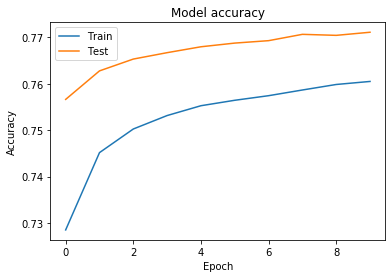

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()